In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # 평균과 로그 분산을 위해 2배
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # 출력값을 0-1로 제한
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=-1)  # 평균과 로그 분산으로 나누기
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)  # 표준편차 계산
        eps = torch.randn_like(std)  # 노이즈 추가
        return mu + eps * std  

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var


![](https://velog.velcdn.com/images/tobigs1617/post/e0486aee-7f50-469f-a6ec-2f45a0d285ea/image.png)

출처: https://velog.io/@gunny1254/Variational-Auto-Encoder-VAE

In [4]:
def loss_function(recon_x, x, mu, log_var):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum') # 재구성 loss
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) # regularization
    return BCE + KLD


In [5]:
model = VAE(input_dim=784, hidden_dim=400, latent_dim=20)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(10): 
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item()}')


Epoch 0 [0/60000] Loss: 70058.171875


Epoch 0 [12800/60000] Loss: 23474.25


Epoch 0 [25600/60000] Loss: 19243.625


Epoch 0 [38400/60000] Loss: 17362.748046875


Epoch 0 [51200/60000] Loss: 16735.962890625


Epoch 1 [0/60000] Loss: 16891.109375


Epoch 1 [12800/60000] Loss: 15550.6103515625


Epoch 1 [25600/60000] Loss: 15041.5849609375


Epoch 1 [38400/60000] Loss: 14970.4755859375


Epoch 1 [51200/60000] Loss: 14772.1943359375


Epoch 2 [0/60000] Loss: 15018.126953125


Epoch 2 [12800/60000] Loss: 14604.990234375


Epoch 2 [25600/60000] Loss: 14846.8662109375


Epoch 2 [38400/60000] Loss: 14386.3798828125


Epoch 2 [51200/60000] Loss: 14111.21484375


Epoch 3 [0/60000] Loss: 14892.701171875


Epoch 3 [12800/60000] Loss: 14455.015625


Epoch 3 [25600/60000] Loss: 14434.890625


Epoch 3 [38400/60000] Loss: 14434.1796875


Epoch 3 [51200/60000] Loss: 14909.234375


Epoch 4 [0/60000] Loss: 14327.32421875


Epoch 4 [12800/60000] Loss: 14425.630859375


Epoch 4 [25600/60000] Loss: 14248.4736328125


Epoch 4 [38400/60000] Loss: 14140.10546875


Epoch 4 [51200/60000] Loss: 14453.12890625


Epoch 5 [0/60000] Loss: 13910.623046875


Epoch 5 [12800/60000] Loss: 14064.572265625


Epoch 5 [25600/60000] Loss: 14366.9580078125


Epoch 5 [38400/60000] Loss: 13979.39453125


Epoch 5 [51200/60000] Loss: 14018.94140625


Epoch 6 [0/60000] Loss: 14178.2666015625


Epoch 6 [12800/60000] Loss: 13506.3037109375


Epoch 6 [25600/60000] Loss: 13474.185546875


Epoch 6 [38400/60000] Loss: 13459.1005859375


Epoch 6 [51200/60000] Loss: 13817.46875


Epoch 7 [0/60000] Loss: 13459.521484375


Epoch 7 [12800/60000] Loss: 13664.248046875


Epoch 7 [25600/60000] Loss: 13700.25390625


Epoch 7 [38400/60000] Loss: 13812.0390625


Epoch 7 [51200/60000] Loss: 14156.7666015625


Epoch 8 [0/60000] Loss: 13856.94140625


Epoch 8 [12800/60000] Loss: 14077.865234375


Epoch 8 [25600/60000] Loss: 13658.751953125


Epoch 8 [38400/60000] Loss: 13315.5791015625


Epoch 8 [51200/60000] Loss: 14059.9580078125


Epoch 9 [0/60000] Loss: 13967.8876953125


Epoch 9 [12800/60000] Loss: 13360.044921875


Epoch 9 [25600/60000] Loss: 13774.1083984375


Epoch 9 [38400/60000] Loss: 13589.396484375


Epoch 9 [51200/60000] Loss: 13561.3876953125


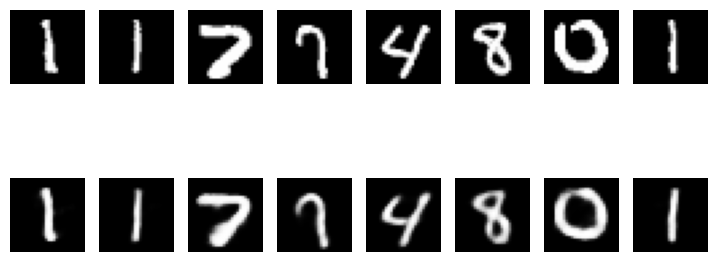

In [6]:
import matplotlib.pyplot as plt

def visualize_reconstruction(model, data_loader):
    model.eval()
    with torch.no_grad():
        for data, _ in data_loader:
            recon_batch, mu, log_var = model(data.view(-1, 784))
            
            plt.figure(figsize=(9, 4))
            n = 8
            for i in range(n):
                ax = plt.subplot(2, n, i + 1)
                plt.imshow(data[i].view(28, 28).numpy(), cmap='gray')
                plt.axis('off')

                ax = plt.subplot(2, n, i + 1 + n)
                plt.imshow(recon_batch[i].view(28, 28).numpy(), cmap='gray')
                plt.axis('off')
            plt.show()
            break  

visualize_reconstruction(model, test_loader)

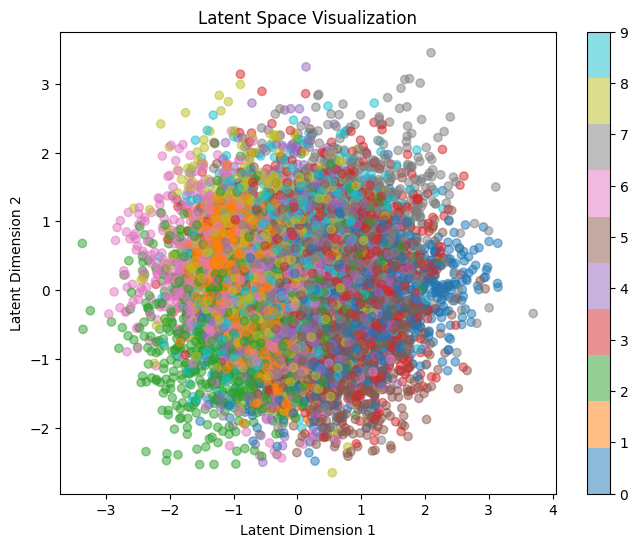

In [7]:
def visualize_latent_space(model, data_loader):
    model.eval()
    with torch.no_grad():
        mu_list = []
        label_list = []
        for data, labels in data_loader:
            mu, log_var = model.encode(data.view(-1, 784))
            mu_list.append(mu)
            label_list.append(labels)
        
        mu = torch.cat(mu_list).numpy()
        labels = torch.cat(label_list).numpy()

        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(mu[:, 0], mu[:, 1], c=labels, cmap='tab10', alpha=0.5)
        plt.colorbar(scatter)
        plt.title('Latent Space Visualization')
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        plt.show()

visualize_latent_space(model, test_loader)